In [1138]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt

FIGSIZE = (20, 6)

In [1139]:
years = [i.name for i in os.scandir(f"inmet-data") if i.is_dir()]
location = "A606"

filenames = []
for year in years:
    filenames.extend(
        [
            f"{year}/{file.name}"
            for file in os.scandir(f"inmet-data/{year}")
            if location in file.name
        ]
    )

filenames.sort()

dfs = []
for f in filenames:
    df = pd.read_csv(f"inmet-data/{f}", delimiter=";", header=8, encoding="iso-8859-1")
    dfs.append(
        df.rename(
            columns={
                "HORA (UTC)": "Hora UTC",
                "DATA (YYYY-MM-DD)": "Data",
                "RADIACAO GLOBAL (Kj/m²)": "RADIACAO GLOBAL (KJ/m²)",
            }
        )
    )

raw_data = pd.concat(dfs).reset_index()
raw_data.head()

,index,Data,Hora UTC,"PRECIPITAÇÃO TOTAL, HORÁRIO (mm)","PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)",PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB),PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB),RADIACAO GLOBAL (KJ/m²),"TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)",TEMPERATURA DO PONTO DE ORVALHO (°C),...,TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C),TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (°C),TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (°C),UMIDADE REL. MAX. NA HORA ANT. (AUT) (%),UMIDADE REL. MIN. NA HORA ANT. (AUT) (%),"UMIDADE RELATIVA DO AR, HORARIA (%)","VENTO, DIREÇÃO HORARIA (gr) (° (gr))","VENTO, RAJADA MAXIMA (m/s)","VENTO, VELOCIDADE HORARIA (m/s)",Unnamed: 19
0,0,2006-09-24,00:00,0,"1011,7","1011,7","1011,2",-9999,"22,5",21,...,"22,4",21,"20,8",92.0,88.0,91.0,110.0,"8,3","3,7",NaN
1,1,2006-09-24,01:00,0,"1011,9","1011,9","1011,7",-9999,"22,7",21,...,"22,4","21,1",21,92.0,90.0,90.0,95.0,6,"3,3",NaN
2,2,2006-09-24,02:00,0,"1011,9","1012,1","1011,8",-9999,"22,6",21,...,"22,5","21,1",21,91.0,90.0,91.0,112.0,"6,1","3,8",NaN
3,3,2006-09-24,03:00,0,"1011,4",1012,"1011,4",-9999,"22,5","21,2",...,"22,5","21,2",21,92.0,91.0,92.0,102.0,"5,6","2,7",NaN
4,4,2006-09-24,04:00,0,"1011,1","1011,6","1011,1",-9999,"22,3","21,2",...,"22,3","21,2","21,1",93.0,92.0,93.0,123.0,"4,8","2,5",NaN


In [1140]:
cols = raw_data.columns

# treating hour data bc it's not super consistent
raw_data[cols[2]] = raw_data[cols[2]].apply(
    lambda s: ":".join([s[:2], s[2:4]]) if isinstance(s, str) and "UTC" in s else s
)
# same for dates
raw_data[cols[1]] = raw_data[cols[1]].apply(
    lambda s: s.replace("/", "-") if isinstance(s, str) else s
)


raw_data["datetime"] = pd.to_datetime(
    raw_data[cols[1]] + " " + raw_data[cols[2]], format="%Y-%m-%d %H:%M"
)


def parseToFloat(col):
    return (
        raw_data[col]
        .apply(lambda x: np.float64(x.replace(",", ".")) if (isinstance(x, str)) else x)
        .apply(lambda x: np.nan if x == -9999.0 else x)
    )


# global-radiation
raw_data["global-radiation"] = parseToFloat(cols[7])

# precipitation
raw_data["total-precipitation"] = parseToFloat(cols[3])

raw_data["relative-humidity"] = parseToFloat("UMIDADE RELATIVA DO AR, HORARIA (%)")

# temperature
raw_data["temperature-last-hour-max"] = parseToFloat(
    "TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)"
)
raw_data["temperature-last-hour-min"] = parseToFloat(
    "TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C)"
)

# wind
raw_data["wind-speed"] = parseToFloat("VENTO, VELOCIDADE HORARIA (m/s)")
raw_data["wind-speed-max-gust"] = parseToFloat("VENTO, RAJADA MAXIMA (m/s)")

raw_data
# removing unused columns and renaming the remainder to more friendly names
renamed_data = raw_data.drop(columns=cols[:21]).set_index("datetime")
renamed_data["datetime"] = renamed_data.index
renamed_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 156504 entries, 2006-09-24 00:00:00 to 2024-07-31 23:00:00
Data columns (total 8 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   global-radiation           92542 non-null   float64       
 1   total-precipitation        146692 non-null  float64       
 2   relative-humidity          135401 non-null  float64       
 3   temperature-last-hour-max  151275 non-null  float64       
 4   temperature-last-hour-min  151275 non-null  float64       
 5   wind-speed                 147375 non-null  float64       
 6   wind-speed-max-gust        147149 non-null  float64       
 7   datetime                   156504 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(7)
memory usage: 10.7 MB


In [1141]:
target = "global-radiation"
idx = "datetime"

df = renamed_data

by_day = (
    renamed_data.groupby([df.index.year, df.index.day_of_year]).mean().set_index(idx)
)

by_day = by_day.loc[by_day[target].notna()]
by_day[idx] = by_day.index
by_day[idx] = by_day[idx].apply(lambda d: d.replace(hour=0, minute=0, second=0))
by_day = by_day.set_index(idx)
by_day.head()

,global-radiation,total-precipitation,relative-humidity,temperature-last-hour-max,temperature-last-hour-min,wind-speed,wind-speed-max-gust
datetime,,,,,,,
2006-09-24,680.200000,0.100000,84.416667,22.541667,21.837500,4.079167,9.795833
2006-09-25,520.430769,0.000000,71.958333,20.908333,20.333333,2.033333,5.708333
2006-09-26,556.330769,0.016667,74.208333,20.283333,19.554167,1.904167,4.904167
2006-09-27,1899.907692,0.000000,62.500000,21.454167,21.029167,5.304167,9.012500
2006-09-28,1948.461538,0.000000,73.454545,21.427273,21.013636,8.468182,13.004545


In [1142]:
fig, ax = plt.subplots(1, 2)
fig.set_figwidth(20)
cap = 2300

ax[0].set_title(f"outliers (value >{cap})")
ax[0].plot(by_day.loc[by_day[target] > cap, target], ".")

ax[1].set_title("radiation values histogram")
ax[1].hist(by_day[target], 100)

plt.tight_layout()

# by_day = by_day.loc[by_day[target] < cap]

'len(train) = 5843 | len(test) = 358'

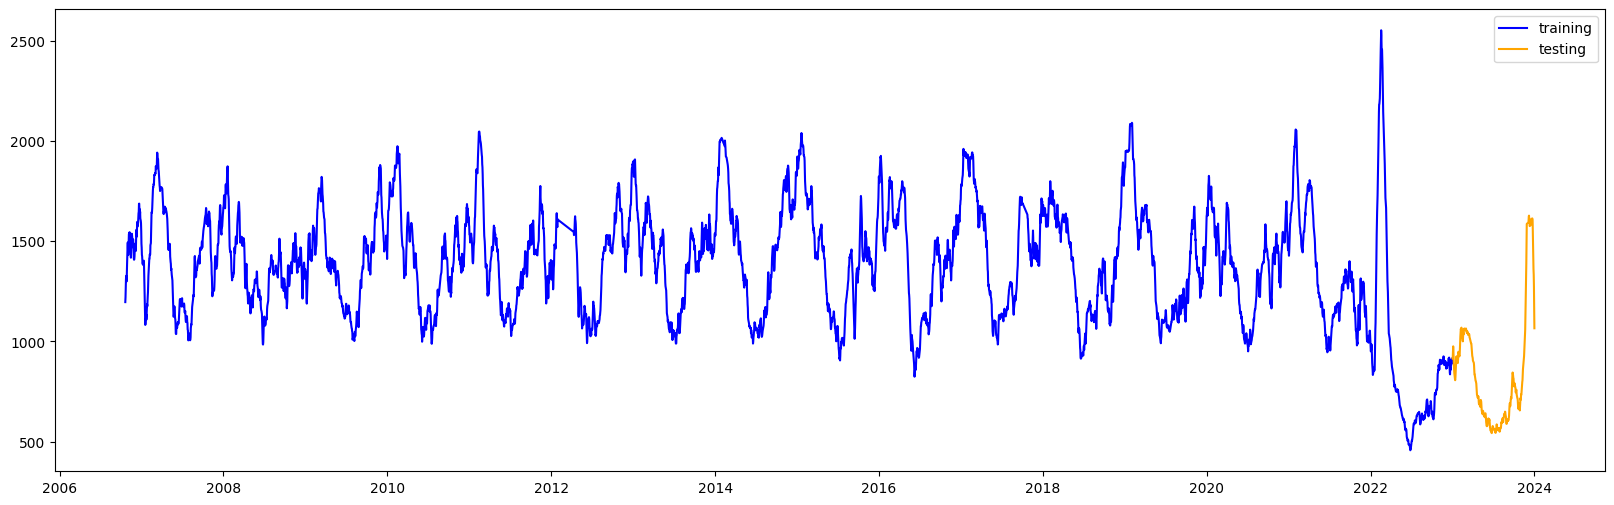

In [ ]:
date_threshold = pd.to_datetime("2023-01-01", format="%Y-%m-%d")
date_upper_threshold = date_threshold + pd.DateOffset(years=1)


def training_threshold(col):
    return col <= date_threshold


def testing_treshold(col):
    return (col >= date_threshold) & (col <= date_upper_threshold)


def split_datasets(df):
    return (
        df[training_threshold(df.index)],  # .dropna(),
        df[testing_treshold(df.index)],  # .dropna(),
    )


def make_rolling_window(df: pd.DataFrame, window_size=28):
    return df.rolling(window=window_size).mean()


train, test = split_datasets(by_day)

by_day_rolling = make_rolling_window(by_day)
train_rolling, test_rolling = split_datasets(by_day_rolling)

plt.figure(figsize=FIGSIZE)
plt.plot(train_rolling[target], color="blue", label="training")
plt.plot(test_rolling[target], color="orange", label="testing")
plt.legend()

f"len(train) = {train[target].size} | len(test) = {test[target].size}"

'error = 0.0159%'

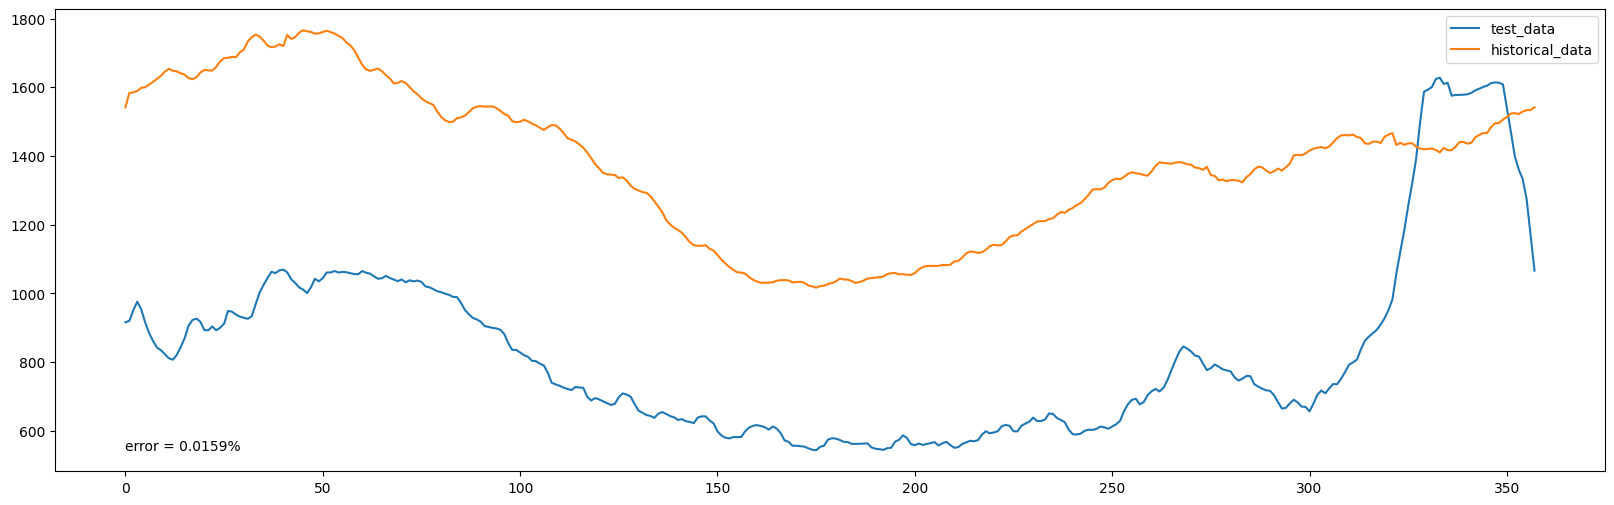

In [ ]:
historical_data = train_rolling.copy()
historical_data["doy"] = historical_data.index.day_of_year
historical_data[idx] = historical_data.index
historical_mean = historical_data.groupby("doy").mean()
historical_mean["doy"] = historical_mean.index
historical_mean[idx] = historical_mean[idx].apply(
    lambda d: d.replace(hour=0, minute=0, second=0, microsecond=0, nanosecond=0)
)
historical_mean = historical_mean.set_index(idx)

test_rolling = test_rolling.copy()
test_rolling["doy"] = test_rolling.index.day_of_year

target_columns = [f"{target}_x", f"{target}_y"]
merged = (
    test_rolling.merge(historical_mean, on="doy")
    .loc[:, target_columns]
    .rename(columns=dict(zip(target_columns, ["test_data", "historical_data"])))
)

from sklearn.metrics import mean_absolute_percentage_error as mape

error = mape(merged.iloc[0], merged.iloc[1])

error_message = f"error = {error:.4f}%"
merged.plot(figsize=FIGSIZE).text(
    merged.index.min(), merged.test_data.min(), error_message
)
error_message

In [ ]:
by_day_rolling.to_csv(f"treated-data/by_day_rolling_{location}.csv")